[Datitos: Aprendizaje profundo](https://datitos.github.io/curso-aprendizaje-profundo/)

[T.P. N°2 - Aprendizaje Profundo 2021 by Datitos](https://www.kaggle.com/c/tp-n2-aprendizaje-profundo-2021-by-datitos-v2)

In [294]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [295]:
import sys
sys.path.append('../lib')

In [306]:
import numpy as np
import pandas as pd

import torch
from torch import nn

from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from IPython.display import clear_output

from utils import try_gpu
from callbacks import PlotLosses, Logger, ReduceLROnPlateau
from data import InputDataIteratorFactory, df_to_tensor

In [307]:
train_set = pd.read_csv('./dataset/fifa2021_training.csv')
test_set  = pd.read_csv('./dataset/fifa2021_test.csv')

In [308]:
# ProfileReport(train_set, title="Exploratory Analisys", explorative=True)to_file("report.html")

In [309]:
SKILL_FEATURES = [
    'BallControl',
    'Dribbling',
    'Marking',
    'SlideTackle',
    'StandTackle',
    'Aggression',
    'Reactions',
    'Interceptions',
    'Vision',
    'Composure',
    'Crossing', 
    'ShortPass',
    'LongPass',
    'Acceleration',
    'Stamina',
    'Strength',
    'Balance',
    'SprintSpeed',
    'Agility',
    'Jumping',
    'Heading',
    'ShotPower',
    'Finishing',
    'LongShots',
    'Curve', 
    'FKAcc',
    'Penalties',
    'Volleys',
    'GKDiving',
    'GKHandling',
    'GKKicking',
    'GKReflexes'
]

TARGET = 'Position'

In [310]:
def preprocess(df): return df[SKILL_FEATURES], pd.get_dummies(df[[TARGET]], dummy_na=True)

In [311]:
X, y = preprocess(train_set)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((9744, 32), (9744, 5), (4177, 32), (4177, 5))

In [335]:
class Model:
    def __init__(self,n_inputs, n_hidden_units, n_outputs, lr=0.01, loss = nn.MSELoss()):
        self.model = nn.Sequential(
            nn.Linear(n_inputs, n_hidden_units),
            nn.ReLU(),
            nn.Linear(n_hidden_units, n_outputs)
        ).to(device=try_gpu())

        self.loss = loss
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    def info(self):
        print('Model:\n', self.model)
        print('Params:\n', [(name, param.shape) for name, param in self.model.named_parameters()])
        return self
    
    def __loss(self, X, y): return self.loss(self.model(X), y)

    def __data_set_loss(self, data_set): return self.__loss(df_to_tensor(data_set[0]), df_to_tensor(data_set[1])).item()

    def __get_metrics(self, train_set, val_set):
        return self.__data_set_loss(train_set), self.__data_set_loss(val_set)

    def parameters(self): return self.model.parameters()

    def fit(self, train_set, val_set, batch_size, n_epochs, verbose = 0, callback_set = CallbackSet()):
        data_iter = InputDataIteratorFactory.create(train_set[0], train_set[1], batch_size)
        callback_set.on_init(self.model, self.optimizer, verbose)

        for epoch in range(n_epochs):
            for X, y in data_iter:
                l = self.__loss(X, y)
                self.optimizer.zero_grad()
                l.backward()
                self.optimizer.step()

            train_loss, val_loss = self.__get_metrics(train_set, val_set)      
            callback_set.on_after_train(self.model, self.optimizer, verbose, epoch, train_loss, val_loss)

In [333]:
model = Model(
    n_inputs       = X_train.shape[1], 
    n_hidden_units = 100, 
    n_outputs      = y_train.shape[1],
    lr             = 0.001
).info()

Model:
 Sequential(
  (0): Linear(in_features=32, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=5, bias=True)
)
Params:
 [('0.weight', torch.Size([100, 32])), ('0.bias', torch.Size([100])), ('2.weight', torch.Size([5, 100])), ('2.bias', torch.Size([5]))]


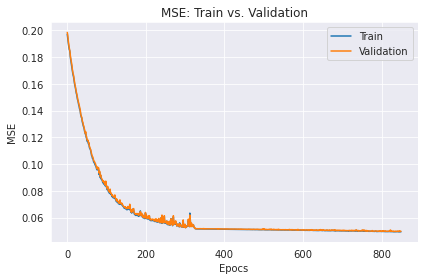

{'epoch': 950, 'train_loss': 0.04934859648346901, 'val_loss': 0.049626436084508896, 'lr': 0.0001}


In [334]:
losses = model.fit(
    train_set    = (X_train, y_train), 
    val_set      = (X_val, y_val),
    batch_size   = 2000,
    n_epochs     = 1000,
    verbose      = 1,
    callback_set = CallbackSet([
        PlotLosses(warmup_count=100),
        Logger(metrics=['epoch', 'train_loss', 'val_loss', 'lr']), 
        ReduceLROnPlateau(patience=20)
    ])
)